In [2]:
import sys
import os
import timeit

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from dmd_machine.dmd_ae_machine import DMDMachine
from dmd_machine.loss_function import LossFunction
from data.Data import DataMaker
from datetime import date
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import train_test_split
from return_stats import *
from create_plots import *
from tensorflow import keras
from datetime import date
import pickle
import time

print(os.getcwd())

D:\Experiments\ROM


In [9]:
import math
import joblib
training_data = joblib.load(open('./data/case1data/original_data2002.pkl', 'rb'))
print(training_data.shape)

two_dimension_data_0=training_data.reshape(training_data.shape[0],12568*2)[0:1601]
two_dimension_data_1=training_data.reshape(training_data.shape[0],12568*2)[1601:2001]


print(two_dimension_data_0.shape)
print(two_dimension_data_1.shape)

(2002, 12568, 2)
(1601, 25136)
(400, 25136)


In [ ]:
import sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=0.90, svd_solver='full')
pca.fit(two_dimension_data_0)
print(pca.explained_variance_ratio_)
pca_data=pca.transform(two_dimension_data_0)
print(pca_data.shape)

In [10]:
scaled_data=two_dimension_data_0
print(scaled_data.shape)

(1601, 25136)


# ***CAE Model***

In [32]:
#Convolutional Autoencoder
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Input,
    Dense,Conv1D, MaxPooling1D, UpSampling1D,
    LSTM,
    Lambda,
    Dropout,
    Flatten,
    Reshape,
    Conv2DTranspose,
)
from tensorflow.keras.models import load_model, Sequential, Model
class ConvolutionalAutoencoder(object):
	"""docstring for Stack_Autoencoder"""
	def __init__(self,input_shape,latent_dim):             
		self.input_shape = input_shape
		self.latent_dim = latent_dim

	def save_model(self, model, model_name, save_dir):
	# function for saving model

		if not os.path.isdir(save_dir):
			os.makedirs(save_dir)
		model_path = os.path.join(save_dir, model_name)
		model.save(model_path)


	def encoder_model(self):
		encoding_dim=self.latent_dim
		inputs = Input(shape=self.input_shape)
		#print(inputs.shape)
		x_3 = Reshape((self.input_shape[0], 1))(inputs)  # Reshape for 1D Convolution
		#print(x_3.shape)
		x = Conv1D(64, 3, activation='relu', padding='same')(x_3)
		x = MaxPooling1D(2, padding='same')(x)
		x = Conv1D(32, 3, activation='relu', padding='same')(x)
		x = MaxPooling1D(2, padding='same')(x)
		x = Conv1D(16, 3, activation='relu', padding='same')(x)
		x = MaxPooling1D(2, padding='same')(x)
		x = Conv1D(8, 3, activation='relu', padding='same')(x)
		x = MaxPooling1D(2, padding='same')(x)
		encoded = Conv1D(4, 3, activation='relu', padding='same')(x)  # Latent representation
		#print(encoded.shape)
        # Flatten and add Dense layers for compression
		encoded = Flatten()(encoded)
		#print(encoded.shape)

		encoded = Dense(encoding_dim * 64, activation='relu')(encoded)
		encoded = Dense(encoding_dim * 32, activation='relu')(encoded)
		encoded = Dense(encoding_dim * 16, activation='relu')(encoded)
		encoded = Dense(encoding_dim * 8, activation='relu')(encoded)
		encoded = Dense(encoding_dim * 4, activation='relu')(encoded)
		encoded = Dense(encoding_dim * 2, activation='relu')(encoded)
		print(encoded.shape)
		code = Dense(encoding_dim)(encoded)
		print("Latent space's dimension:",code.shape)
        
		encoder = Model(inputs=inputs, outputs=code, name='encoder') # from input to code
		#encoder.summary()
		return encoder

	def decoder_model(self):
		encoding_dim=self.latent_dim
		latent_inputs = Input(shape=(self.latent_dim,))
		decoded = Dense(encoding_dim * 2, activation='relu')(latent_inputs)
		decoded = Dense(encoding_dim * 4, activation='relu')(decoded)
		decoded = Dense(encoding_dim * 8, activation='relu')(decoded)
		decoded = Dense(encoding_dim * 16, activation='relu')(decoded)
		decoded = Dense(encoding_dim * 32, activation='relu')(decoded)
		decoded = Dense(encoding_dim * 64, activation='relu')(decoded)

		x = Dense(6284, activation='relu')(decoded)
		x = Reshape((1571, 4))(x)
		x = Conv1D(8, 3, activation='relu', padding='same')(x)
		x = UpSampling1D(2)(x)
		x = Conv1D(16, 3, activation='relu', padding='same')(x)
		x = UpSampling1D(2)(x)
		x = Conv1D(32, 3, activation='relu', padding='same')(x)
		x = UpSampling1D(2)(x)
		x = Conv1D(64, 3, activation='relu', padding='same')(x)
		x = UpSampling1D(2)(x)
		decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x)
		decoded=Reshape((self.input_shape))(decoded) # Reshape to input's shape
        
		decoder= Model(inputs=latent_inputs, outputs=decoded, name="decoder")
		#decoder.summary()

		return decoder


	def load_model(self,encoding_dim):
        # Create encoder and decoder
		self.encoder = self.encoder_model()
		self.decoder = self.decoder_model()
        # Create autoencoder by chaining encoder and decoder
		input_dim = Input(shape=self.input_shape)
		self.encoder.summary()
		self.decoder.summary()


		# link encoder and decoder
		encoder_img = self.encoder(input_dim) #call the encoder
		decoder_img = self.decoder(encoder_img) #call the decoder
		self.autoencoder = Model(inputs=input_dim, outputs=decoder_img, name='autoencoder') #build autoencoder


	def train_model(self, train, validation, test, epochs, batch_size, model_save_folder, encoder_file_name, decoder_file_name, AE_file_name):
		check_model = ModelCheckpoint(model_save_folder + '/' + AE_file_name,
									monitor='val_loss',
									save_best_only=True,
									verbose=1)
		reduce_LR = ReduceLROnPlateau(monitor='val_loss',
									factor=0.5,
									patience=5,
									verbose=1,
									mode='min',
									min_delta=1e-10,
									cooldown=0,
									min_lr=0)

		self.history_record = self.autoencoder.fit(train, train,
                        epochs = epochs,
                        batch_size = batch_size,
                        callbacks=[check_model, reduce_LR],
                        validation_data=(validation, validation))

		# draw_Acc_Loss(self.history_record)
		self.save_model(self.encoder, encoder_file_name, model_save_folder)
		self.save_model(self.decoder, decoder_file_name, model_save_folder)
		self.save_model(self.autoencoder, AE_file_name, model_save_folder)
		self.save_model(self.autoencoder, AE_file_name, model_save_folder)

		print(" DeepAE model trained successfully")

		scores = self.autoencoder.evaluate(test, test, batch_size, verbose=1)

		print('Test loss:', scores[0], '\nTest accuracy:', scores[1])

In [ ]:
#Training the CAE models
from sklearn.model_selection import train_test_split


#Create a directory
directory_name='AE_Models_case1_CAE'
if(os.path.isdir(directory_name)):
    print("The directory already exist, please continue.")    
else:
    os.mkdir(directory_name)
    print("The directory was created, please continue.")
    
model_save_folder = './AE_Models_case1_CAE'

encoding_dim_array=[83,62,37,17,13,7,4]
time_spending=[]
for encoding_dim in encoding_dim_array:    
    #start time
    start_time=timeit.default_timer()
    
    encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
    decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
    AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model
    
    batch_size = 32
    epochs = 400

    train_set, test = train_test_split(scaled_data, test_size=0.2, random_state=1)
    train, validation = train_test_split(train_set, test_size=0.1, random_state=2)
    print(train.shape)

    ae = ConvolutionalAutoencoder(input_shape=(scaled_data.shape[1],), latent_dim=encoding_dim)

    if os.path.exists(model_save_folder + "/" + AE_file_name):

        ae.autoencoder = load_model(model_save_folder + "/" + AE_file_name)
        ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
        ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

        ae.autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        ae.autoencoder.summary()

        ae.train_model(train, validation, test, epochs, batch_size, model_save_folder, encoder_file_name, decoder_file_name, AE_file_name)


    else:
        ae.load_model(encoding_dim)
        #ae.autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        ae.autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        ae.autoencoder.summary()
        
        ae.train_model(train, validation, test, epochs, batch_size, model_save_folder, encoder_file_name, decoder_file_name, AE_file_name)

    #end time
    end_time=timeit.default_timer()
    print("time spend for prediction:",end_time - start_time)
    time_spending.append(end_time - start_time)
print("time_spending",time_spending)

In [6]:
#Stacked Autoencoder
import os
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Input,
    Dense,
    LSTM,
    Lambda,
    Dropout,
    Flatten,
    Reshape,
    Conv2DTranspose,
)
from tensorflow.keras.models import load_model, Sequential, Model
class StackAutoencoder(object):
	"""docstring for Stack_Autoencoder"""
	def __init__(self):
		super(StackAutoencoder, self).__init__()


	def save_model(self, model, model_name, save_dir):
	# function for saving model

		if not os.path.isdir(save_dir):
			os.makedirs(save_dir)
		model_path = os.path.join(save_dir, model_name)
		model.save(model_path)


	def encoder_model(self, input_dim, encoding_dim):


		encoded = Dense(encoding_dim * 8, activation='relu')(input_dim)
		encoded = Dense(encoding_dim * 4, activation='relu')(encoded)
		encoded = Dense(encoding_dim * 2, activation='relu')(encoded)
		code = Dense(encoding_dim)(encoded)

		return code

	def decoder_model(self, vtu_data, code, encoding_dim):

		decoded = Dense(encoding_dim * 2, activation='relu')(code)
		decoded = Dense(encoding_dim * 4, activation='relu')(decoded)
		decoded = Dense(encoding_dim * 8, activation='relu')(decoded)

		decoded = Dense(vtu_data.shape[1], activation='sigmoid')(decoded)

		return decoded


	def load_model(self, vtu_data, encoding_dim):

		input_dim = Input(shape=(vtu_data.shape[1]))
		encoder_output = self.encoder_model(input_dim, encoding_dim)
		self.encoder = Model(inputs=input_dim, outputs=encoder_output, name='encoder') # from input to code
		# self.encoder.summary()


		# Create a encoder model 
		decoder_input = Input(shape=(encoding_dim)) #the input of the encoder 
		decoder_output = self.decoder_model(vtu_data, decoder_input, encoding_dim)
		self.decoder = Model(inputs=decoder_input, outputs=decoder_output, name="decoder")
		# self.decoder.summary()


		# connect the encoder and decoder model
		encoder_img = self.encoder(input_dim) # call the encoder model
		decoder_img = self.decoder(encoder_img) #call the decoder model
		self.autoencoder = Model(inputs=input_dim, outputs=decoder_img, name='autoencoder') #construct the autoencoder model

	def train_model(self, train, validation, test, epochs, batch_size, model_save_folder, encoder_file_name, decoder_file_name, AE_file_name):

		check_model = ModelCheckpoint(model_save_folder + '/' + AE_file_name,
									monitor='val_loss',
									save_best_only=True,
									verbose=1)
		reduce_LR = ReduceLROnPlateau(monitor='val_loss',
									factor=0.5,
									patience=5,
									verbose=1,
									mode='min',
									min_delta=1e-10,
									cooldown=0,
									min_lr=0)

		self.history_record = self.autoencoder.fit(train, train,
                        epochs = epochs,
                        batch_size = batch_size,
                        callbacks=[check_model, reduce_LR],
                        validation_data=(validation, validation))

		# draw_Acc_Loss(self.history_record)
		self.save_model(self.encoder, encoder_file_name, model_save_folder)
		self.save_model(self.decoder, decoder_file_name, model_save_folder)
		self.save_model(self.autoencoder, AE_file_name, model_save_folder)
		self.save_model(self.autoencoder, AE_file_name, model_save_folder)

		print(" DeepAE model trained successfully")

		scores = self.autoencoder.evaluate(test, test, batch_size, verbose=1)

		print('Test loss:', scores[0], '\nTest accuracy:', scores[1])


In [ ]:
#Training the SAE models
from sklearn.model_selection import train_test_split

#Create a directory
directory_name='AE_Models_case1'
if(os.path.isdir(directory_name)):
    print("The directory already exist, please continue.")    
else:
    os.mkdir(directory_name)
    print("The directory was created, please continue.")
    
model_save_folder = './AE_Models_case1'

encoding_dim_array=[83,62,37,17,6,4]
time_spending=[]
for encoding_dim in encoding_dim_array:    
    #start time
    start_time=timeit.default_timer()
    
    encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
    decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
    AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model
    
    batch_size = 32
    epochs = 300

    train_set, test = train_test_split(scaled_data, test_size=0.2, random_state=1)
    train, validation = train_test_split(train_set, test_size=0.1, random_state=2)
    print(train.shape)

    ae = StackAutoencoder()

    if os.path.exists(model_save_folder + "/" + AE_file_name):

        ae.autoencoder = load_model(model_save_folder + "/" + AE_file_name)
        ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
        ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)

        ae.autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        ae.autoencoder.summary()

        ae.train_model(train, validation, test, epochs, batch_size, model_save_folder, encoder_file_name, decoder_file_name, AE_file_name)


    else:
        ae.load_model(train, encoding_dim)
        ae.autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        ae.autoencoder.summary()
        
        ae.train_model(train, validation, test, epochs, batch_size, model_save_folder, encoder_file_name, decoder_file_name, AE_file_name)

    #end time
    end_time=timeit.default_timer()
    print("time spend for prediction:",end_time - start_time)
    time_spending.append(end_time - start_time)
print("time_spending",time_spending)

In [117]:
#Code of Dynamic Mode Decomposition
class DMD(object):
  def y_plus(self,y_data):
    """ the encoded output data without the first time series state. """
    return y_data[:, 1:]

  def y_minus(self,y_data):
    """ the encoded output data without the last time series state. """
    return y_data[:, :-1]

  def get_amat(self,y_data,r):
    """ Compute DMD A matrix by the singular value decomposition. """
    X2 = self.y_plus(y_data)
    X1 = self.y_minus(y_data)
    # compute A using the pseudoinverse.
    # return y_plus2 @ tf.linalg.pinv(y_minus2)
    ## Perform singular value decomposition on X1
    u, s, v = np.linalg.svd(X1, full_matrices=False)
    print("Singular value matrix's shape",s.shape)
    print("Singular value array",s)
    ## Compute the Koopman matrix
    A_tilde = u[:, : r].conj().T @ X2 @ v[: r, :].conj().T * np.reciprocal(s[: r])
    ## Perform eigenvalue decomposition on A_tilde
    Phi, Q = np.linalg.eig(A_tilde)
    ## Compute the coefficient matrix
    Psi = X2 @ v[: r, :].conj().T @ np.diag(np.reciprocal(s[: r])) @ Q
    A = Psi @ np.diag(Phi) @ np.linalg.pinv(Psi)
    return A

  def get_predicted_y(self,y_data,r,pred_step):
    #data=np.array(y_data)[:,0:-pred_step]
    data = np.array(y_data)[:,:]
    N, T = data.shape
    A = self.get_amat(data, r)
    print(A.shape)
    print(A)
    mat2 = np.append(data, np.zeros((N, pred_step)), axis=1)
    #print(mat2.shape)
    for s in range(pred_step):
        mat2[:, T + s] =(A @ mat2[:, T + s - 1]).real#
    return mat2[:,pred_step:]

# ***For original snapshots***

In [ ]:
#Comparison of DMD and SAE-DMD on extrapolation
#Prediction of DMD
pred_time_steps=400
encoding_dim_array=[83,62,37,17,6,4]
model_save_folder = './AE_Models_case1'

for encoding_dim in encoding_dim_array:    
    dmd=DMD()
    # start timer.
    start_time = timeit.default_timer()

    y_pred = dmd.get_predicted_y(tf.transpose(scaled_data),int(encoding_dim),pred_time_steps)# rank equals 10 and estimate time step equals 10

    print("y_pred_before_transpose",y_pred.shape)
    y_pred=tf.transpose(y_pred)
    print("y_pred",y_pred.shape)

    #Reconstructed data of DMD prediction
    outputs=np.array(y_pred).reshape(scaled_data.shape[0],12568,2)
    u = outputs[:,:,0]
    v = outputs[:,:,1]
    scaler_u = joblib.load('./data/case1data/scaler_u.pkl')
    scaler_v = joblib.load('./data/case1data/scaler_v.pkl')
    outputs_u = scaler_u.inverse_transform(u)
    outputs_v = scaler_v.inverse_transform(v)
    outputs = np.dstack((outputs_u, outputs_v))
    pickle.dump(outputs, open(os.path.join(model_save_folder, "full_pre_y_"+str(encoding_dim)+"_"+str(pred_time_steps)+"_DMD.pkl"), "wb"))
    
    print("time spend for prediction:",timeit.default_timer() - start_time)

In [ ]:
#Prediction of SAE-DMD
encoding_dim =83#83,62,37,17,13,7,4

encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model
ae = StackAutoencoder()
ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)
# start timer.
start_time = timeit.default_timer()

#AE+DMD
import joblib
y=ae.encoder(two_dimension_data_0)
print(y.shape)
x_ae=ae.decoder(y)
print(x_ae.shape)
outputs=np.array(x_ae).reshape(two_dimension_data_0.shape[0],12568,2)
u = outputs[:,:,0]
v = outputs[:,:,1]
scaler_u = joblib.load('./data/case1data/scaler_u.pkl')
scaler_v = joblib.load('./data/case1data/scaler_v.pkl')
outputs_u = scaler_u.inverse_transform(u)
outputs_v = scaler_v.inverse_transform(v)
outputs = np.dstack((outputs_u, outputs_v))
#pickle.dump(outputs, open(os.path.join(model_save_folder, "full_x_ae_"+str(encoding_dim)+"_1601.pkl"), "wb"))

dmd=DMD()
#y_pred = dmd.get_predicted_y(tf.transpose(y),int(encoding_dim),pred_time_steps)# rank equals 10 and estimate time step equals 10
y_pred = dmd.get_predicted_y(tf.transpose(y),int(encoding_dim),pred_time_steps)
print("y_pred_before_transpose",y_pred.shape)
y_pred=tf.transpose(y_pred)
print("y_pred",y_pred.shape)
# decode predicted latent space.
y_pred_dec = ae.decoder(y_pred)
print(y_pred_dec.shape)

#Reconstructed data of DMD prediction
outputs=np.array(y_pred_dec).reshape(two_dimension_data_0.shape[0],12568,2)
u = outputs[:,:,0]
v = outputs[:,:,1]
scaler_u = joblib.load('./data/case1data/scaler_u.pkl')
scaler_v = joblib.load('./data/case1data/scaler_v.pkl')
outputs_u = scaler_u.inverse_transform(u)
outputs_v = scaler_v.inverse_transform(v)
outputs = np.dstack((outputs_u, outputs_v))
pickle.dump(outputs, open(os.path.join(model_save_folder, "full_pre_y_"+str(encoding_dim)+"_"+str(pred_time_steps)+"_unseen.pkl"), "wb"))

print(timeit.default_timer() - start_time)

In [ ]:
#The comparison of CAE and SAE on reconstruction
#Reconstruction of CAE
import joblib
encoding_dim_array =[83,62,37,17,13,7,4]
for encoding_dim in encoding_dim_array:
    model_save_folder = './AE_Models_case1_CAE'
    encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
    decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
    AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model
    ae = ConvolutionalAutoencoder((scaled_data.shape[1],),encoding_dim)
    ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
    ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)
    
    # start timer.
    start_time = timeit.default_timer()

    y=ae.encoder(two_dimension_data_0)
    print(y.shape)
    x_ae=ae.decoder(y)
    print(x_ae.shape)
    outputs=np.array(x_ae).reshape(two_dimension_data_0.shape[0],12568,2)
    u = outputs[:,:,0]
    v = outputs[:,:,1]
    scaler_u = joblib.load('./data/case1data/scaler_u.pkl')
    scaler_v = joblib.load('./data/case1data/scaler_v.pkl')
    outputs_u = scaler_u.inverse_transform(u)
    outputs_v = scaler_v.inverse_transform(v)
    outputs = np.dstack((outputs_u, outputs_v))
    model_save_folder_2 = './AE_Models_case1'
    pickle.dump(outputs, open(os.path.join(model_save_folder, "full_x_ae_"+str(encoding_dim)+"_CAE.pkl"), "wb"))
    print(timeit.default_timer() - start_time)

In [ ]:
#Reconstruction of SAE
encoding_dim_array =[83,62,37,17,13,7,4]
for encoding_dim in encoding_dim_array:
    model_save_folder = './AE_Models_case1'
    encoder_file_name = 'AE_encoder_dim' + str(encoding_dim) # name of encoder model
    decoder_file_name = 'AE_decoder_dim' + str(encoding_dim) # name of decoder model
    AE_file_name = 'AE_dim' + str(encoding_dim) # name of AE whole model
    ae = StackedAutoencoder()
    ae.encoder = load_model(model_save_folder + "/" + encoder_file_name)
    ae.decoder = load_model(model_save_folder + "/" + decoder_file_name)
    
    # start timer.
    start_time = timeit.default_timer()
    
    y=ae.encoder(two_dimension_data_0)
    print(y.shape)
    x_ae=ae.decoder(y)
    print(x_ae.shape)
    outputs=np.array(x_ae).reshape(two_dimension_data_0.shape[0],12568,2)
    u = outputs[:,:,0]
    v = outputs[:,:,1]
    scaler_u = joblib.load('./data/case1data/scaler_u.pkl')
    scaler_v = joblib.load('./data/case1data/scaler_v.pkl')
    outputs_u = scaler_u.inverse_transform(u)
    outputs_v = scaler_v.inverse_transform(v)
    outputs = np.dstack((outputs_u, outputs_v))
    pickle.dump(outputs, open(os.path.join(model_save_folder, "full_x_ae_"+str(encoding_dim)+"_SAE.pkl"), "wb"))
    print(timeit.default_timer() - start_time)

# ***Output***

In [4]:
def cal_Magnitude(data):
    three_dimension_data=np.array(data).transpose(1,2,0)

    two_dimension_data=np.zeros((three_dimension_data.shape[0], three_dimension_data.shape[2]), dtype=np.float32)
    #print(two_dimension_data.shape)
    for i in range(0, three_dimension_data.shape[0]):
        for j in range(0, three_dimension_data.shape[2]):
            magnitude=math.sqrt(pow(three_dimension_data[i,0,j],2)+pow(three_dimension_data[i,1,j],2))
            two_dimension_data[i][j]=magnitude
    two_dimension_data=two_dimension_data.reshape(two_dimension_data.shape[1],two_dimension_data.shape[0])
    return two_dimension_data

**Comparison of SAE and CAE on reconstruction**

In [ ]:
#Fig.5. PerformancecomparisonbetweenSAEandCAEintermsofdimensionalityreduction
import math
import joblib
import pickle
encoding_dim =4#83,62,37,17,13,7,4
model_save_folder = './AE_Models_case1'
model_save_folder_2 = './AE_Models_case1_CAE'

#Create a directory
directory_name='TempdataCase1'
if(os.path.isdir(directory_name)):
    print("The directory already exist, please continue.")    
else:
    os.mkdir(directory_name)
    print("The directory was created, please continue.")


ori_data = np.load(open('./data/case1data/Velocity.npy', 'rb'))
print(ori_data.shape)
ori_data3=cal_Magnitude(ori_data)
pickle.dump(ori_data3, open("./TempdataCase1/ori_data3.pkl", "wb"))

rom_data_0=joblib.load(open(os.path.join(model_save_folder, "full_x_ae_"+str(encoding_dim)+"_SAE.pkl"), "rb"))
rom_data_03=cal_Magnitude(rom_data_0)
pickle.dump(rom_data_03, open("./TempdataCase1/rom_data_03.pkl", "wb"))
rom_data_1=joblib.load(open(os.path.join(model_save_folder_2, "full_x_ae_"+str(encoding_dim)+"_CAE.pkl"), "rb"))#
rom_data_13=cal_Magnitude(rom_data_1)
pickle.dump(rom_data_13, open("./TempdataCase1/rom_data_13.pkl", "wb"))

encoding_dim =17
rom_data_2=joblib.load(open(os.path.join(model_save_folder, "full_x_ae_"+str(encoding_dim)+"_SAE.pkl"), "rb"))
rom_data_23=cal_Magnitude(rom_data_2)
pickle.dump(rom_data_23, open("./TempdataCase1/rom_data_23.pkl", "wb"))
rom_data_3=joblib.load(open(os.path.join(model_save_folder_2, "full_x_ae_"+str(encoding_dim)+"_CAE.pkl"), "rb"))#
rom_data_33=cal_Magnitude(rom_data_3)
pickle.dump(rom_data_33, open("./TempdataCase1/rom_data_33.pkl", "wb"))

encoding_dim =37
rom_data_4=joblib.load(open(os.path.join(model_save_folder, "full_x_ae_"+str(encoding_dim)+"_SAE.pkl"), "rb"))
rom_data_43=cal_Magnitude(rom_data_4)
pickle.dump(rom_data_43, open("./TempdataCase1/rom_data_43.pkl", "wb"))
rom_data_5=joblib.load(open(os.path.join(model_save_folder_2, "full_x_ae_"+str(encoding_dim)+"_CAE.pkl"), "rb"))#
rom_data_53=cal_Magnitude(rom_data_5)
pickle.dump(rom_data_53, open("./TempdataCase1/rom_data_53.pkl", "wb"))

encoding_dim =83
rom_data_6=joblib.load(open(os.path.join(model_save_folder, "full_x_ae_"+str(encoding_dim)+"_SAE.pkl"), "rb"))
rom_data_63=cal_Magnitude(rom_data_6)
pickle.dump(rom_data_63, open("./TempdataCase1/rom_data_63.pkl", "wb"))
rom_data_7=joblib.load(open(os.path.join(model_save_folder_2, "full_x_ae_"+str(encoding_dim)+"_CAE.pkl"), "rb"))#
rom_data_73=cal_Magnitude(rom_data_7)
pickle.dump(rom_data_73, open("./TempdataCase1/rom_data_73.pkl", "wb"))

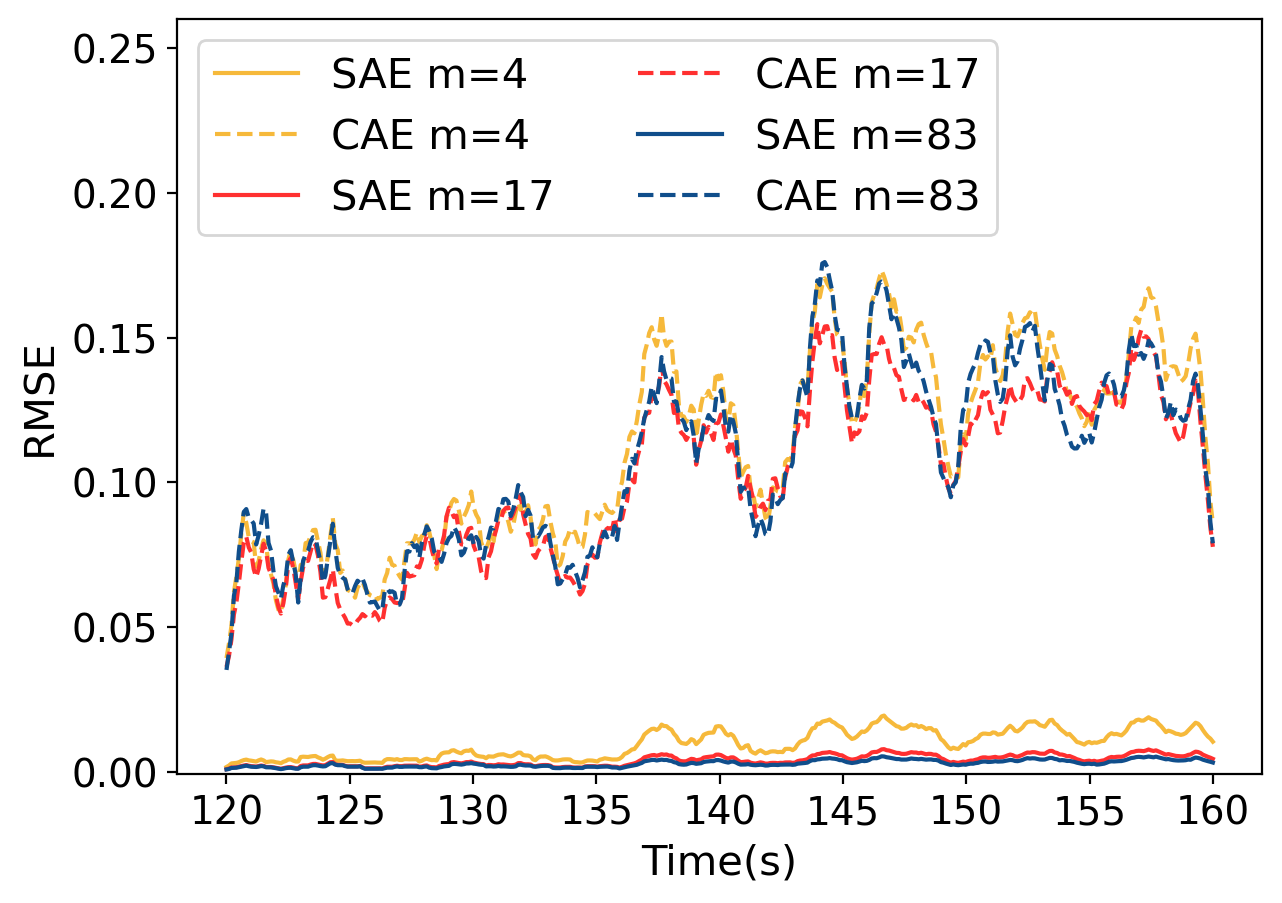

In [4]:
import joblib
import pickle
ori_data2=joblib.load(open('./TempdataCase1/ori_data3.pkl', 'rb'))[-400:0]

rom_data_02=joblib.load(open('./TempdataCase1/rom_data_03.pkl', 'rb'))[-400:0]
rom_data_12=joblib.load(open('./TempdataCase1/rom_data_13.pkl', 'rb'))[-400:0]

rom_data_22=joblib.load(open('./TempdataCase1/rom_data_23.pkl', 'rb'))[-400:0]
rom_data_32=joblib.load(open('./TempdataCase1/rom_data_33.pkl', 'rb'))[-400:0]

rom_data_42=joblib.load(open('./TempdataCase1/rom_data_63.pkl', 'rb'))[-400:0]
rom_data_52=joblib.load(open('./TempdataCase1/rom_data_73.pkl', 'rb'))[-400:0]

from dmd_machine import Model_Processing_7inputs_2_CAE as MP
MP.rmse_over_time(ori_data2, rom_data_02, rom_data_12,rom_data_22,rom_data_32,rom_data_42,rom_data_52,'Velocity',0.26,120)

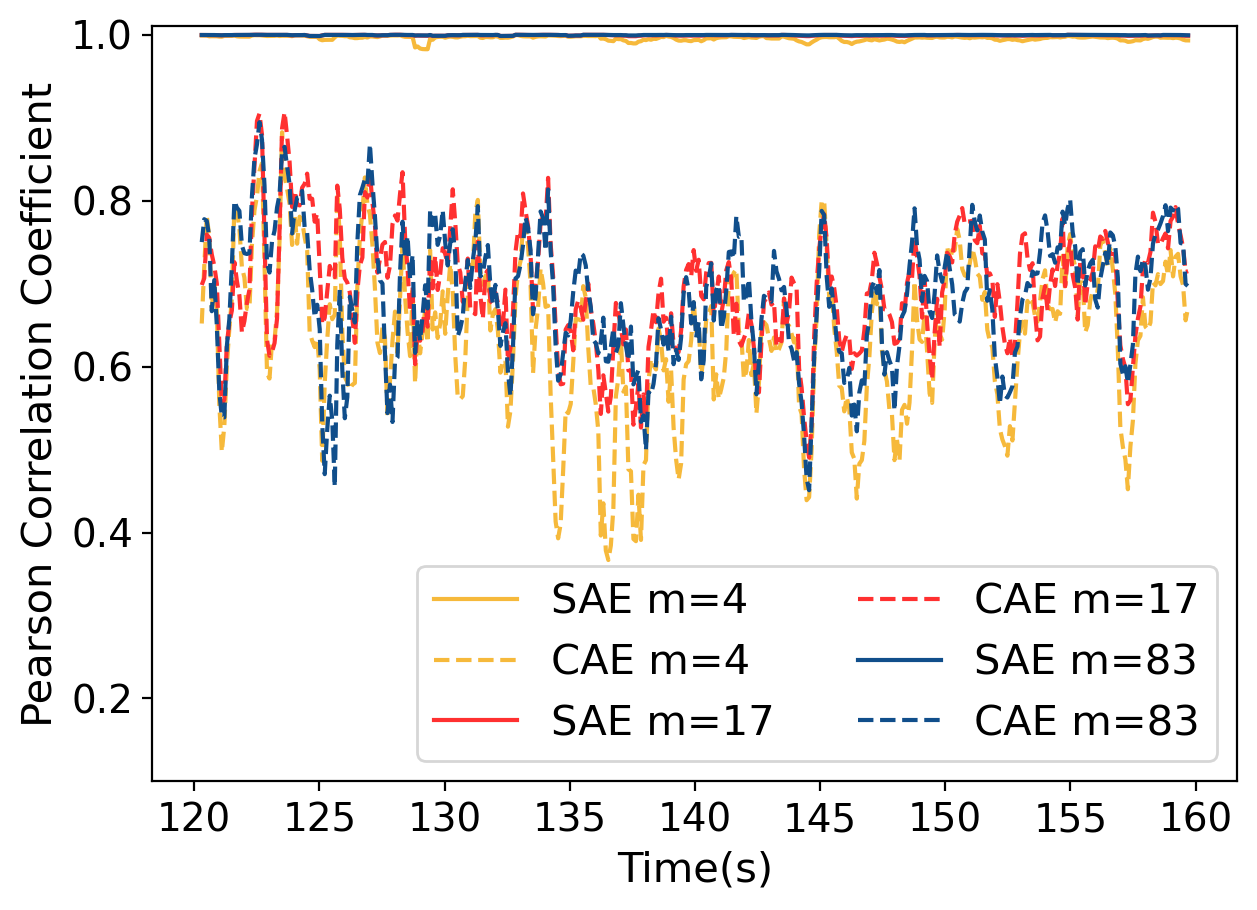

In [5]:
MP.cc(ori_data2, rom_data_02, rom_data_12,rom_data_22,rom_data_32,rom_data_42,rom_data_52,0.1,'Velocity',120)

In [ ]:
#Fig. 7. Performance comparison between the classical DMD models and the developed SAE-DMD models in terms of prediction accuracy
import math
import joblib
import pickle
encoding_dim =37#83,62,37,17,13,7,4
model_save_folder = './AE_Models_case1'
ori_data = np.load(open('./data/case1data/Velocity.npy', 'rb'))[-400:]
print(ori_data.shape)
ori_data3=cal_Magnitude(ori_data)
pickle.dump(ori_data3, open("./TempdataCase1/ori_data3.pkl", "wb"))
rom_data_0=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(encoding_dim)+"_400_DMD.pkl"), "rb"))[-400:]
rom_data_03=cal_Magnitude(rom_data_0)
pickle.dump(rom_data_03, open("./TempdataCase1/rom_data_03.pkl", "wb"))
#rom_data_0 =rom_data_0.reshape(2002,12568*2)[0:2000,:]
rom_data_1=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(encoding_dim)+"_400_unseen.pkl"), "rb"))[-400:]
rom_data_13=cal_Magnitude(rom_data_1)
pickle.dump(rom_data_13, open("./TempdataCase1/rom_data_13.pkl", "wb"))
print(rom_data_13.shape)

In [136]:
import joblib
import pickle
ori_data2=joblib.load(open('./TempdataCase1/ori_data3.pkl', 'rb'))
rom_data_02=joblib.load(open('./TempdataCase1/rom_data_03.pkl', 'rb'))
rom_data_12=joblib.load(open('./TempdataCase1/rom_data_13.pkl', 'rb'))

from dmd_machine import Model_Processing_3inputs_2 as MP

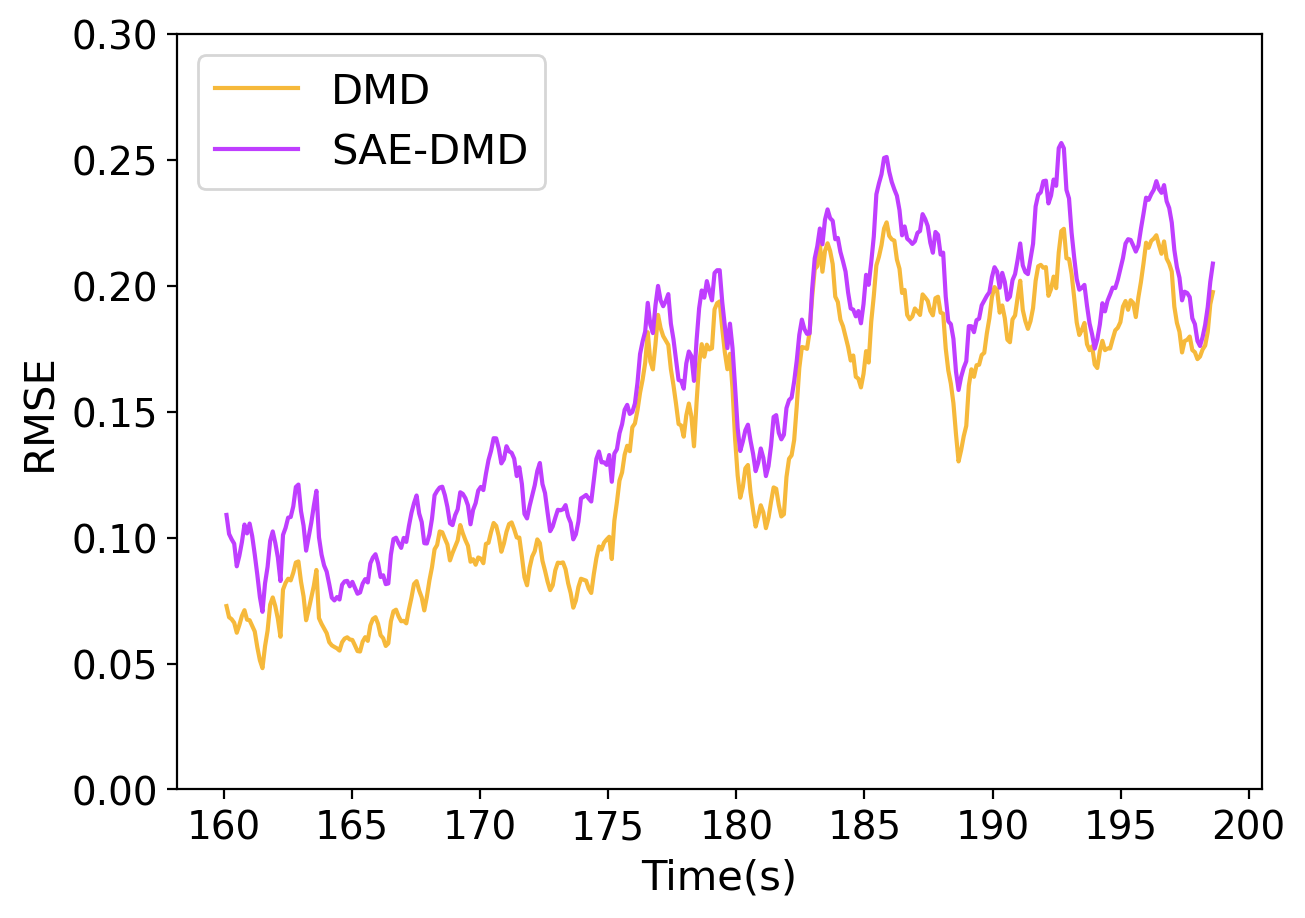

In [137]:
MP.rmse_over_time(ori_data2, rom_data_02, rom_data_12,'Velocity',0.3,160)

In [ ]:
MP.cc(ori_data2, rom_data_02, rom_data_12,0.0,'Velocity',160)

In [ ]:
# Fig. 6. The influence of the rank value 𝑟 on the prediction performance of DMD models
import joblib
import math
import numpy as np
import pickle

model_save_folder = './AE_Models_case1'
ori_data = np.load(open('./data/case1data/Velocity.npy', 'rb'))[-400:]
print(ori_data.shape)
ori_data3=cal_Magnitude(ori_data)
pickle.dump(ori_data3, open("./TempdataCase1/ori_data3.pkl", "wb"))
rom_data_0=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(4)+"_400_DMD.pkl"), "rb"))[-400:]
rom_data_03=cal_Magnitude(rom_data_0)
pickle.dump(rom_data_03, open("./TempdataCase1/rom_data_03.pkl", "wb"))
rom_data_1=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(7)+"_400_DMD.pkl"), "rb"))[-400:]
rom_data_13=cal_Magnitude(rom_data_1)
pickle.dump(rom_data_13, open("./TempdataCase1/rom_data_13.pkl", "wb"))
rom_data_2=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(17)+"_400_DMD.pkl"), "rb"))[-400:]
rom_data_23=cal_Magnitude(rom_data_2)
pickle.dump(rom_data_23, open("./TempdataCase1/rom_data_23.pkl", "wb"))
rom_data_3=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(37)+"_400_DMD.pkl"), "rb"))[-400:]
rom_data_33=cal_Magnitude(rom_data_3)
pickle.dump(rom_data_33, open("./TempdataCase1/rom_data_33.pkl", "wb"))
rom_data_4=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(62)+"_400_DMD.pkl"), "rb"))[-400:]
rom_data_43=cal_Magnitude(rom_data_4)
pickle.dump(rom_data_43, open("./TempdataCase1/rom_data_43.pkl", "wb"))
rom_data_5=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(83)+"_400_DMD.pkl"), "rb"))[-400:]
rom_data_53=cal_Magnitude(rom_data_5)
pickle.dump(rom_data_53, open("./TempdataCase1/rom_data_53.pkl", "wb"))

In [ ]:
import joblib
import pickle
ori_data2=joblib.load(open('./TempdataCase1/ori_data3.pkl', 'rb'))
rom_data_02=joblib.load(open('./TempdataCase1/rom_data_03.pkl', 'rb'))
rom_data_12=joblib.load(open('./TempdataCase1/rom_data_13.pkl', 'rb'))
rom_data_22=joblib.load(open('./TempdataCase1/rom_data_23.pkl', 'rb'))
rom_data_32=joblib.load(open('./TempdataCase1/rom_data_33.pkl', 'rb'))
rom_data_42=joblib.load(open('./TempdataCase1/rom_data_43.pkl', 'rb'))
rom_data_52=joblib.load(open('./TempdataCase1/rom_data_53.pkl', 'rb'))
from dmd_machine import Model_Processing_7inputs_2 as MP

(400, 12568)


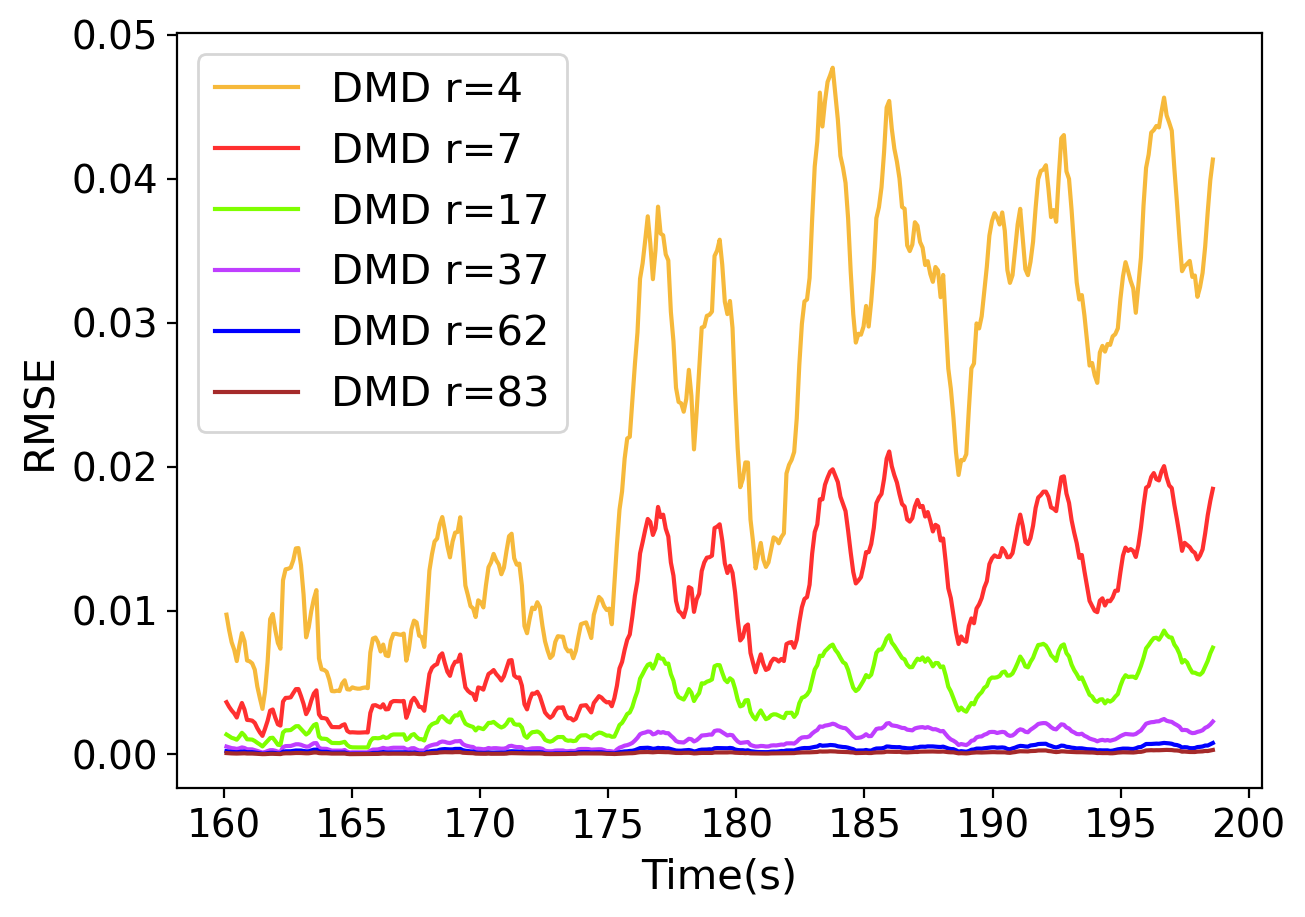

In [11]:
print(ori_data2.shape)
MP.rmse_over_time(ori_data2, rom_data_02, rom_data_12, rom_data_22,rom_data_32,rom_data_42,rom_data_52,'Velocity',160,'upper left')


In [ ]:
MP.cc(ori_data2, rom_data_02, rom_data_12, rom_data_22,rom_data_32,rom_data_42,rom_data_52,'Velocity',160,'lower left')


In [ ]:
# Fig. 12. The absolute errors of the reduced-order solutions of velocity magnitudes at a specified point over time
model_save_folder = './AE_Models_case1'
ori_data = np.load(open('./data/case1data/Velocity.npy', 'rb'))[-400:]
print(ori_data.shape)
ori_data3=cal_Magnitude(ori_data)
pickle.dump(ori_data3, open("./TempdataCase1/ori_data3.pkl", "wb"))
rom_data_0=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(37)+"_400_unseen.pkl"), "rb"))[-400:]
rom_data_03=cal_Magnitude(rom_data_0)
pickle.dump(rom_data_03, open("./TempdataCase1/rom_data_03.pkl", "wb"))
#rom_data_0 =rom_data_0.reshape(2002,12568*2)[0:2000,:]
rom_data_1=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(17)+"_400_unseen.pkl"), "rb"))[-400:]
rom_data_13=cal_Magnitude(rom_data_1)
pickle.dump(rom_data_13, open("./TempdataCase1/rom_data_13.pkl", "wb"))
#rom_data_1 =rom_data_1.reshape(2002,12568*2)[0:2000,:]
rom_data_2=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(13)+"_400_unseen.pkl"), "rb"))[-400:]
rom_data_23=cal_Magnitude(rom_data_2)
pickle.dump(rom_data_23, open("./TempdataCase1/rom_data_23.pkl", "wb"))
print(rom_data_23.shape)
rom_data_3=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(7)+"_400_unseen.pkl"), "rb"))[-400:]
rom_data_33=cal_Magnitude(rom_data_3)
pickle.dump(rom_data_33, open("./TempdataCase1/rom_data_33.pkl", "wb"))
print(rom_data_33.shape)

In [ ]:
import joblib
import pickle
ori_data2=joblib.load(open('./TempdataCase1/ori_data3.pkl', 'rb'))
rom_data_02=joblib.load(open('./TempdataCase1/rom_data_03.pkl', 'rb'))
rom_data_12=joblib.load(open('./TempdataCase1/rom_data_13.pkl', 'rb'))
rom_data_22=joblib.load(open('./TempdataCase1/rom_data_23.pkl', 'rb'))
rom_data_32=joblib.load(open('./TempdataCase1/rom_data_33.pkl', 'rb'))
from dmd_machine import Model_Processing_5inputs_2 as MP

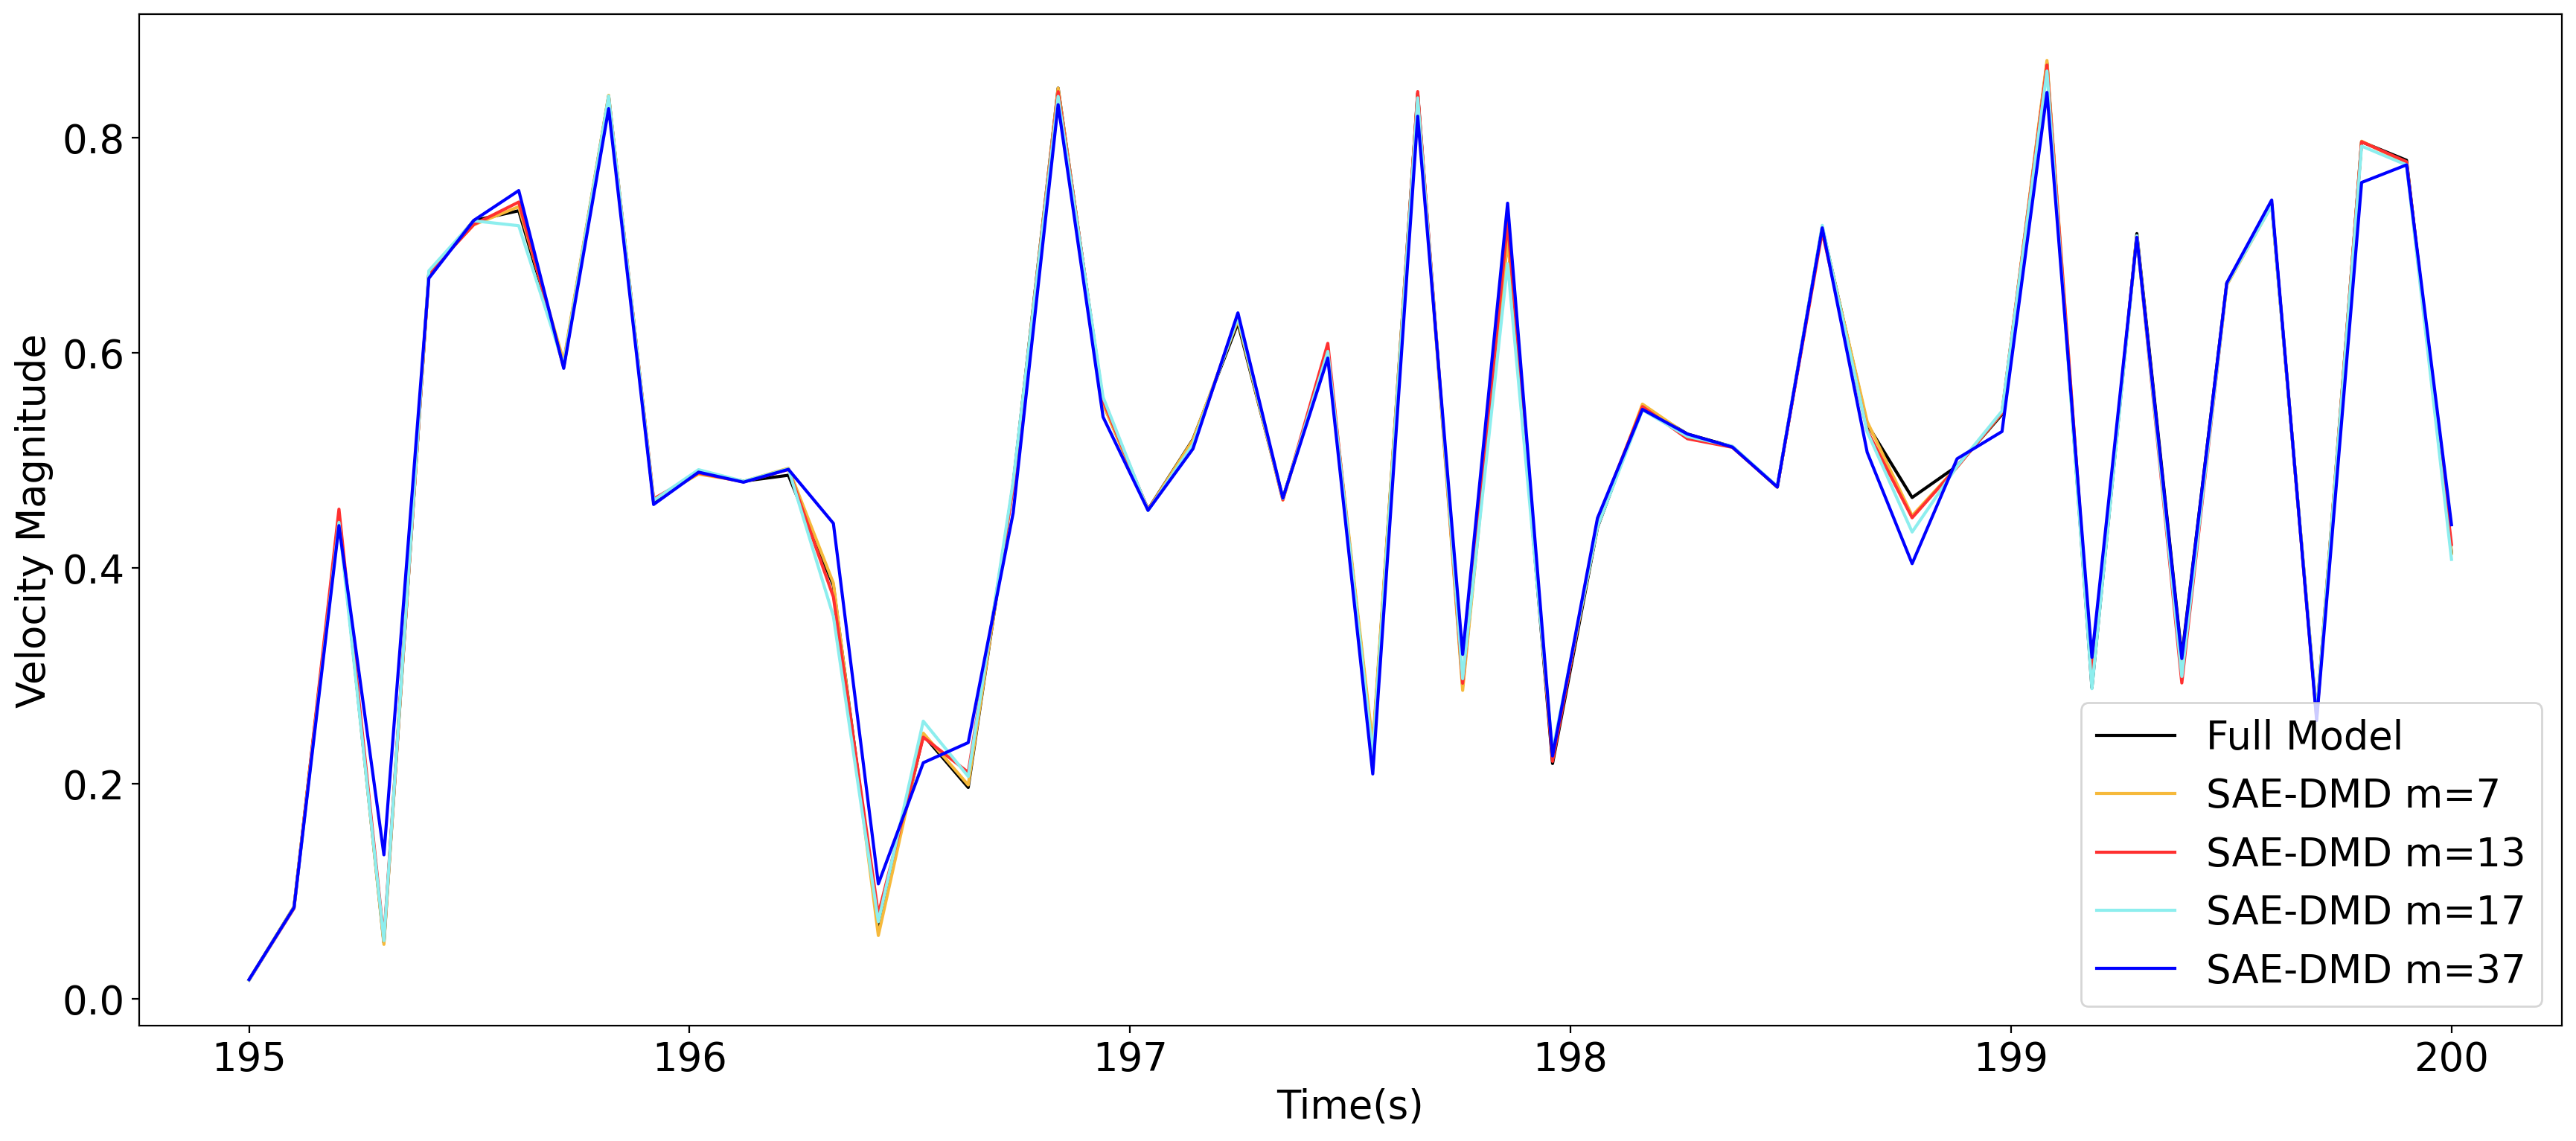

In [6]:
MP.point_over_time(ori_data2[-50:], rom_data_02[-50:], rom_data_12[-50:], rom_data_22[-50:],rom_data_32[-50:],5169,'Velocity',195,'lower right')
#MP.point_over_time(ori_data2, rom_data_02, rom_data_12, rom_data_22,5169,'Velocity')

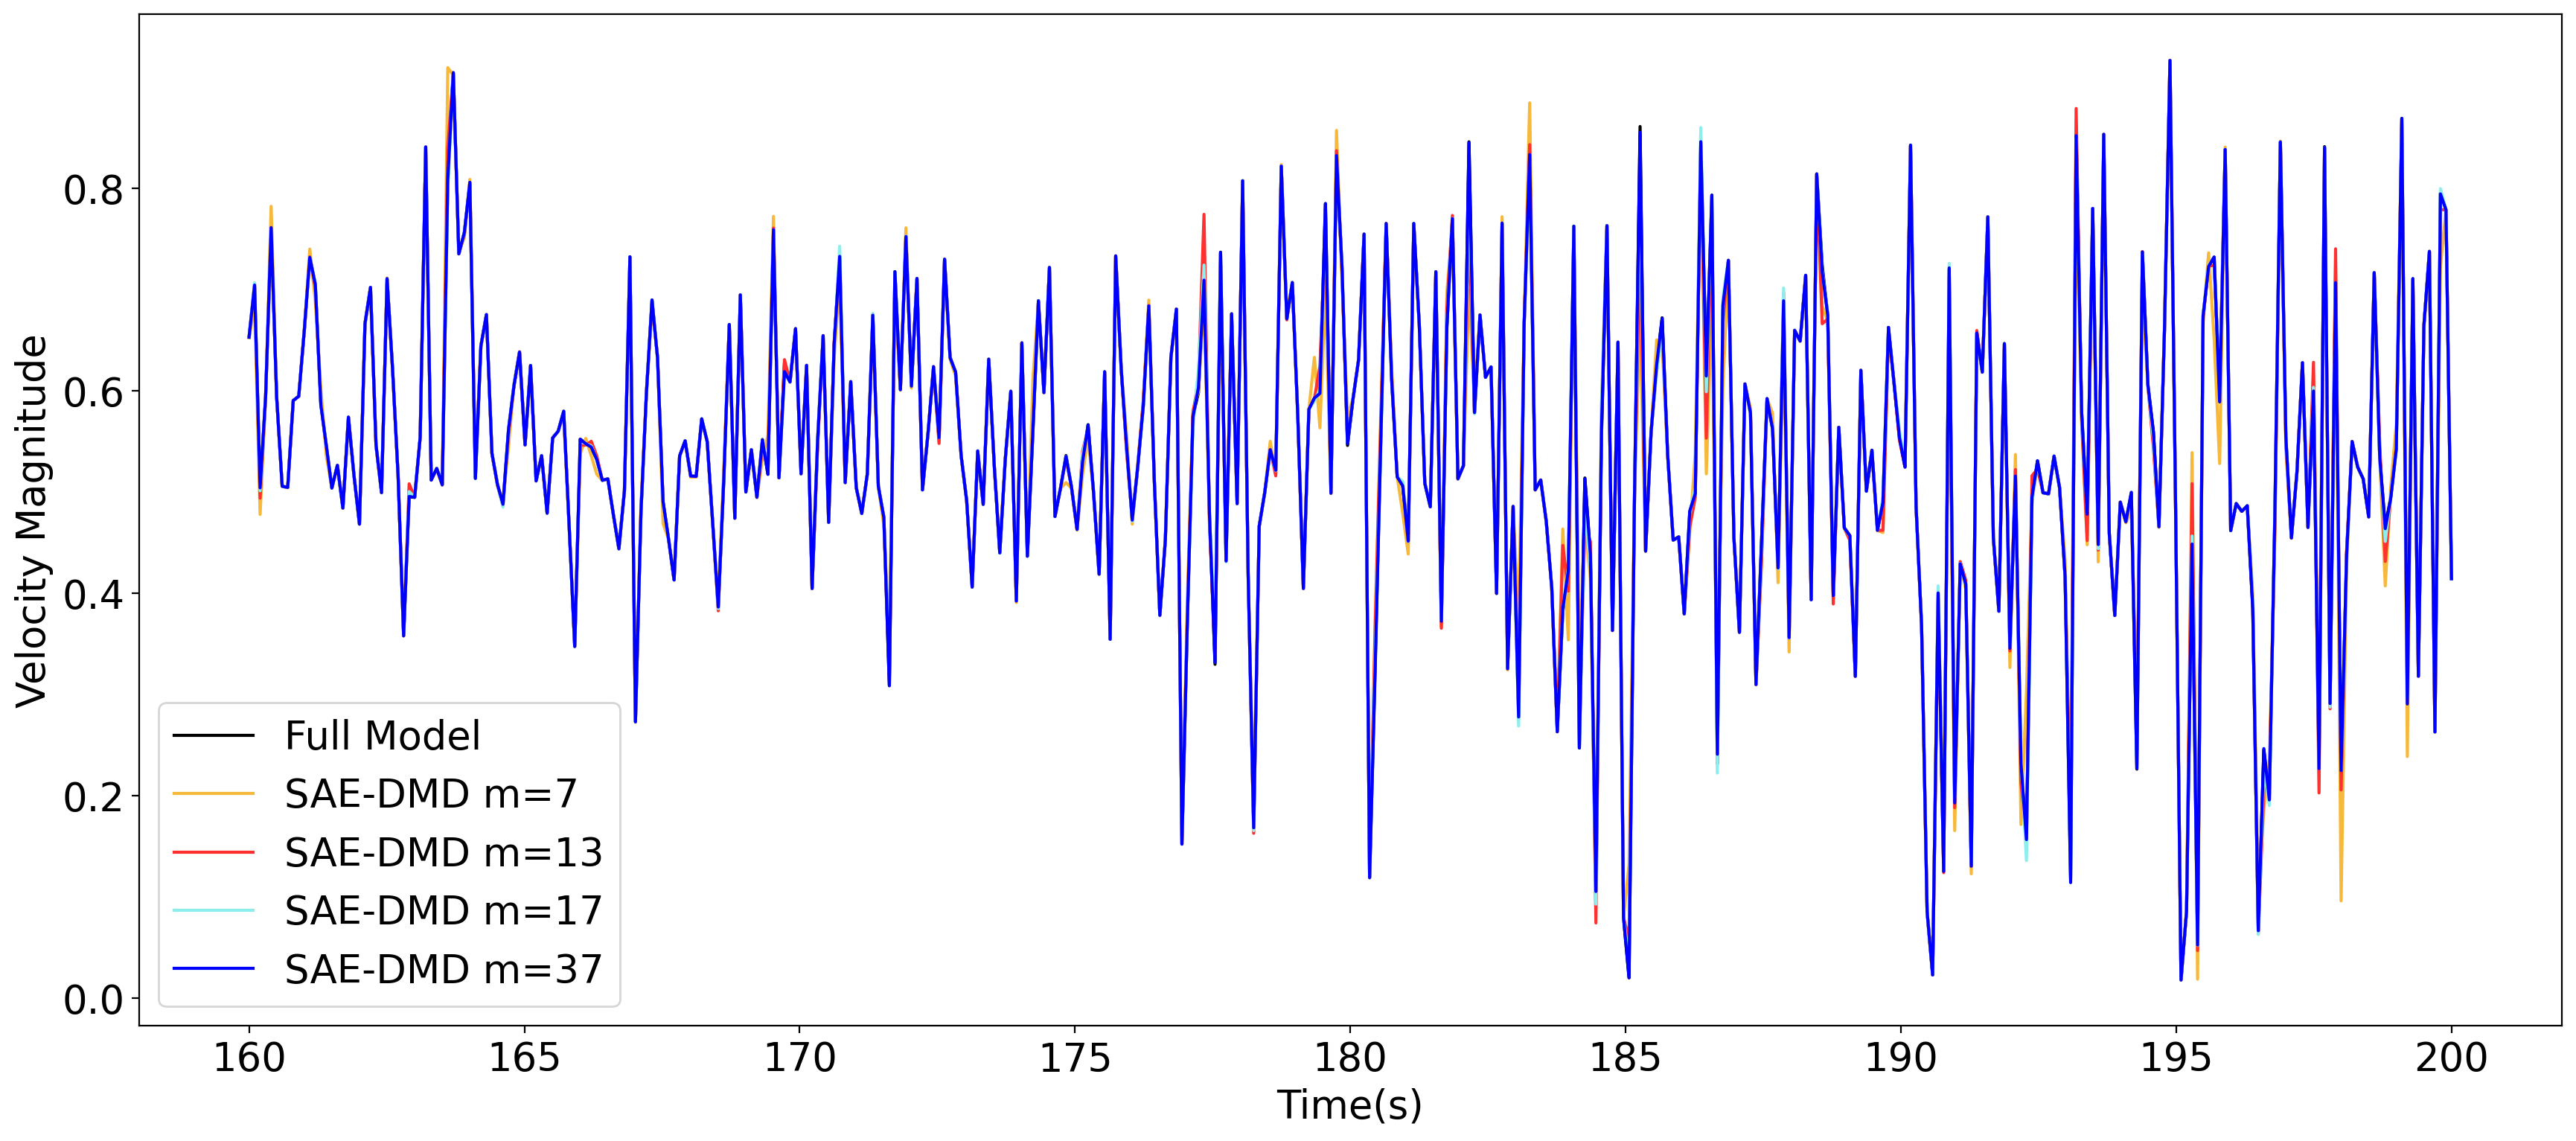

In [8]:
MP.point_over_time(ori_data2, rom_data_02, rom_data_12, rom_data_22,rom_data_32,5169,'Velocity',160,'lower left')

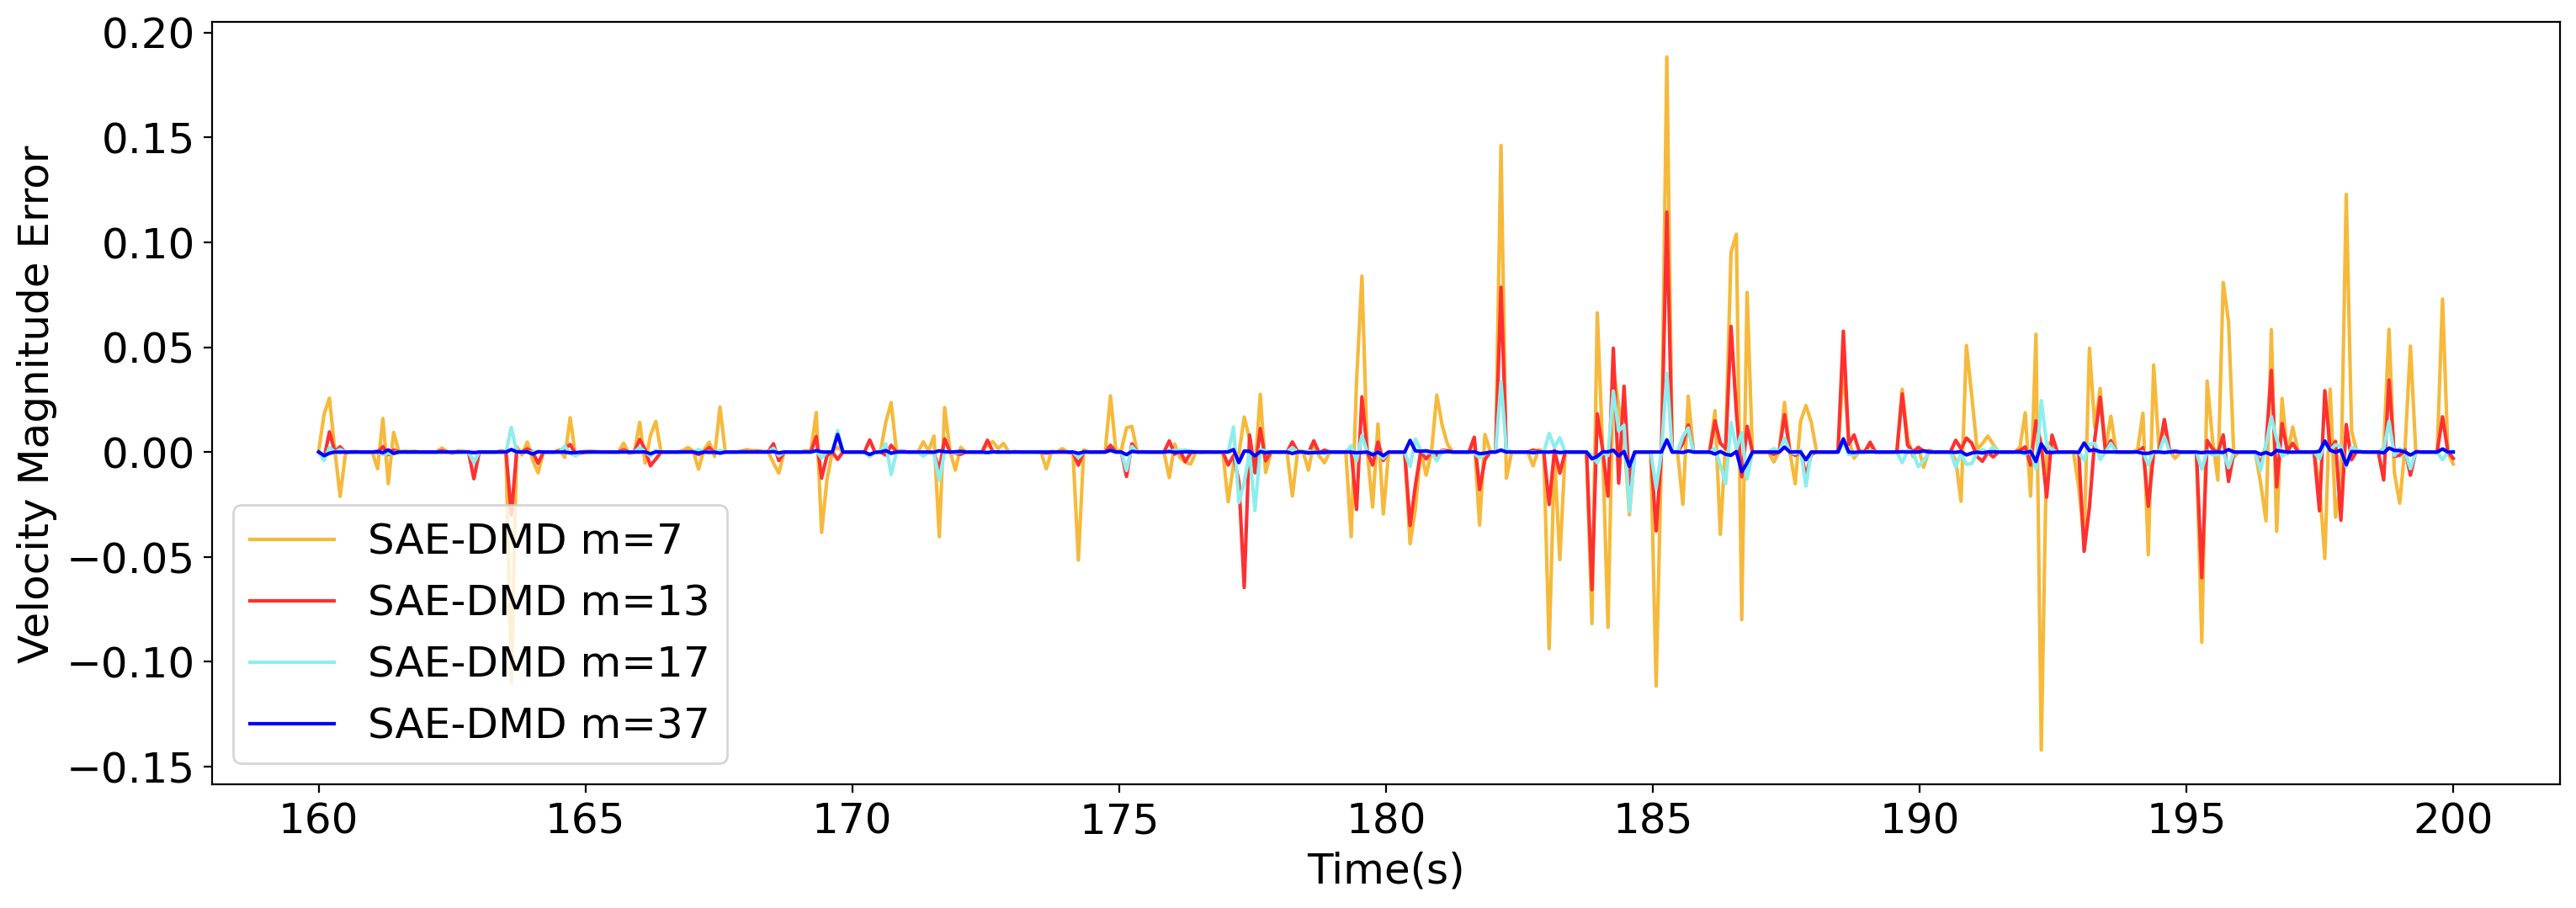

In [7]:
MP.point_over_time_error(ori_data2, rom_data_02,rom_data_12,rom_data_22,rom_data_32,5169,'Velocity',160,'lower left')

In [40]:
# Fig. 8. the reduced-order solutions predicted from the SAE-DMD models with varying code lengths
import numpy as np
import joblib
from dmd_machine import Model_Processing_5inputs_2 as MP
model_save_folder = './AE_Models_case1'
file_name = '/circle-2d-drag_'# name for each vtu file
field_name = 'Velocity2'# name of selected field

In [ ]:
pred_time_steps=400
encoding_dim_array =[83,62,37,17,13,7,4]
for encoding_dim in encoding_dim_array:
    #for Unseen data
    print(encoding_dim)
    rom_data_1=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(encoding_dim)+"_"+str(pred_time_steps)+"_unseen.pkl"), "rb"))[-400:]
    print(rom_data_1.shape)
    MP.transform_vector(rom_data_1, rom_data_1.shape[0], './flow_past_cylinder_2002', './flow_past_cylinder_unseen'+"_"+str(pred_time_steps),	file_name, field_name)

# ***Errors***

In [ ]:
# Fig. 9. The absolute errors between the velocity solutions obtained from the numerical CFD model and the SAE-DMD models with varying code lengths
import joblib
import math
import numpy as np
import pickle
model_save_folder = './AE_Models_case1'
pred_time_steps=400

ori_data = np.load(open('./data/case1data/Velocity.npy', 'rb'))[-400:]
print(ori_data.shape)

rom_data_0=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(37)+"_"+str(pred_time_steps)+"_unseen.pkl"), "rb"))[-400:]

rom_data_1=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(17)+"_"+str(pred_time_steps)+"_unseen.pkl"), "rb"))[-400:]

rom_data_2=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(13)+"_"+str(pred_time_steps)+"_unseen.pkl"), "rb"))[-400:]

rom_data_3=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(7)+"_"+str(pred_time_steps)+"_unseen.pkl"), "rb"))[-400:]

rom_data_4=joblib.load(open(os.path.join(model_save_folder, "full_pre_y_"+str(4)+"_"+str(pred_time_steps)+"_unseen.pkl"), "rb"))[-400:]

rom_error0=ori_data-rom_data_0
rom_error1=ori_data-rom_data_1
rom_error2=ori_data-rom_data_2
rom_error3=ori_data-rom_data_3
rom_error4=ori_data-rom_data_4

In [14]:
import numpy as np
from dmd_machine import Model_Processing_5inputs_2 as MP
file_name = '/circle-2d-drag_'# name for each vtu file
field_name = 'Error'# name of selected field

MP.transform_vector(rom_error0, rom_data_0.shape[0], './flow_past_cylinder_2002', './flow_past_cylinder_37_error',	file_name, field_name)
MP.transform_vector(rom_error1, rom_data_1.shape[0], './flow_past_cylinder_2002', './flow_past_cylinder_17_error',	file_name, field_name)
MP.transform_vector(rom_error2, rom_data_2.shape[0], './flow_past_cylinder_2002', './flow_past_cylinder_13_error',	file_name, field_name)
MP.transform_vector(rom_error3, rom_data_3.shape[0], './flow_past_cylinder_2002', './flow_past_cylinder_7_error', file_name, field_name)
MP.transform_vector(rom_error4, rom_data_4.shape[0], './flow_past_cylinder_2002', './flow_past_cylinder_4_error', file_name, field_name)

start to store data as a new variable
transform succeed
